In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from statsmodels.tsa.stattools import coint
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

In [3]:
crypto_forex_stocks = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 
                       'EOS-USD', 'XTZ-USD', 'ALGO-USD', 'XMR-USD', 'KCS-USD', 'MKR-USD', 'BSV-USD', 'RUNE-USD', 'DASH-USD', 
                       'KAVA-USD', 'ICX-USD', 'LINA-USD', 'WAXP-USD', 'LSK-USD', 'EWT-USD', 'XCN-USD', 'HIVE-USD', 'FTX-USD', 
                       'RVN-USD', 'SXP-USD', 'BTCB-USD']
bank_stocks = ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN', 'ING', ' BNPQY', 'HSBC', 'SMFG', 'PNC', 'USB', 
               'BK', 'STT', 'KEY', 'RF', 'HBAN', 'FITB',  'CFG', 'BLK', 'ALLY', 'MTB', 'NBHC', 'ZION', 'FFIN', 'FHN', 'UBSI', 
               'WAL', 'PACW', 'SBCF', 'TCBI', 'BOKF', 'PFG', 'GBCI', 'TFC', 'CFR', 'UMBF', 'SPFI', 'FULT', 'ONB', 'INDB', 'IBOC',
                'HOMB']
global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225', '^HSI', '^AXJO', '^KS11', '^BFX', '^N100',
                  '^RUT', '^VIX', '^TNX']

start = '2021-01-01'
end = '2023-12-31'
tickers = crypto_forex_stocks + bank_stocks + global_indexes
tickers_map = {ticker: yf.Ticker(ticker).history(start=start, end=end) for ticker in tickers}

 BNPQY: No timezone found, symbol may be delisted


In [4]:
def clean_data(data_map):
    for data in data_map.values():
        data.index = pd.to_datetime(data.index).tz_localize(None)
        
    df = pd.concat([data['Close'] for data in data_map.values()], axis=1, keys=data_map.keys())

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.interpolate(method='cubic', inplace=True)
    df.fillna(method='pad', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.dropna(axis=1, how='all', inplace=True)

    return df    

In [5]:
cleaned_data = clean_data(tickers_map)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1094 entries, 2021-01-01 to 2023-12-30
Freq: D
Data columns (total 89 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BTC-USD   1094 non-null   float64
 1   ETH-USD   1094 non-null   float64
 2   BNB-USD   1094 non-null   float64
 3   XRP-USD   1094 non-null   float64
 4   ADA-USD   1094 non-null   float64
 5   DOGE-USD  1094 non-null   float64
 6   ETC-USD   1094 non-null   float64
 7   XLM-USD   1094 non-null   float64
 8   AAVE-USD  1094 non-null   float64
 9   EOS-USD   1094 non-null   float64
 10  XTZ-USD   1094 non-null   float64
 11  ALGO-USD  1094 non-null   float64
 12  XMR-USD   1094 non-null   float64
 13  KCS-USD   1094 non-null   float64
 14  MKR-USD   1094 non-null   float64
 15  BSV-USD   1094 non-null   float64
 16  RUNE-USD  1094 non-null   float64
 17  DASH-USD  1094 non-null   float64
 18  KAVA-USD  1094 non-null   float64
 19  ICX-USD   1094 non-null   float64
 20  LINA

In [6]:
def coint_matrix(df):
    tickers = df.columns
    p_values = np.ones((len(tickers), len(tickers)))
    close_matrix = np.column_stack([df[ticker] for ticker in tickers])
    for i, j in combinations(range(len(tickers)), 2):
        result = coint(close_matrix[:, i], close_matrix[:, j])
        if result[1] < 0.05:
            p_values[i, j] = result[1]

    pairs = [(tickers[i], tickers[j], p_values[i, j]) for i, j in zip(*np.where(p_values < 0.05))]

    return p_values, pairs

In [7]:
p_values, pairs = coint_matrix(cleaned_data)

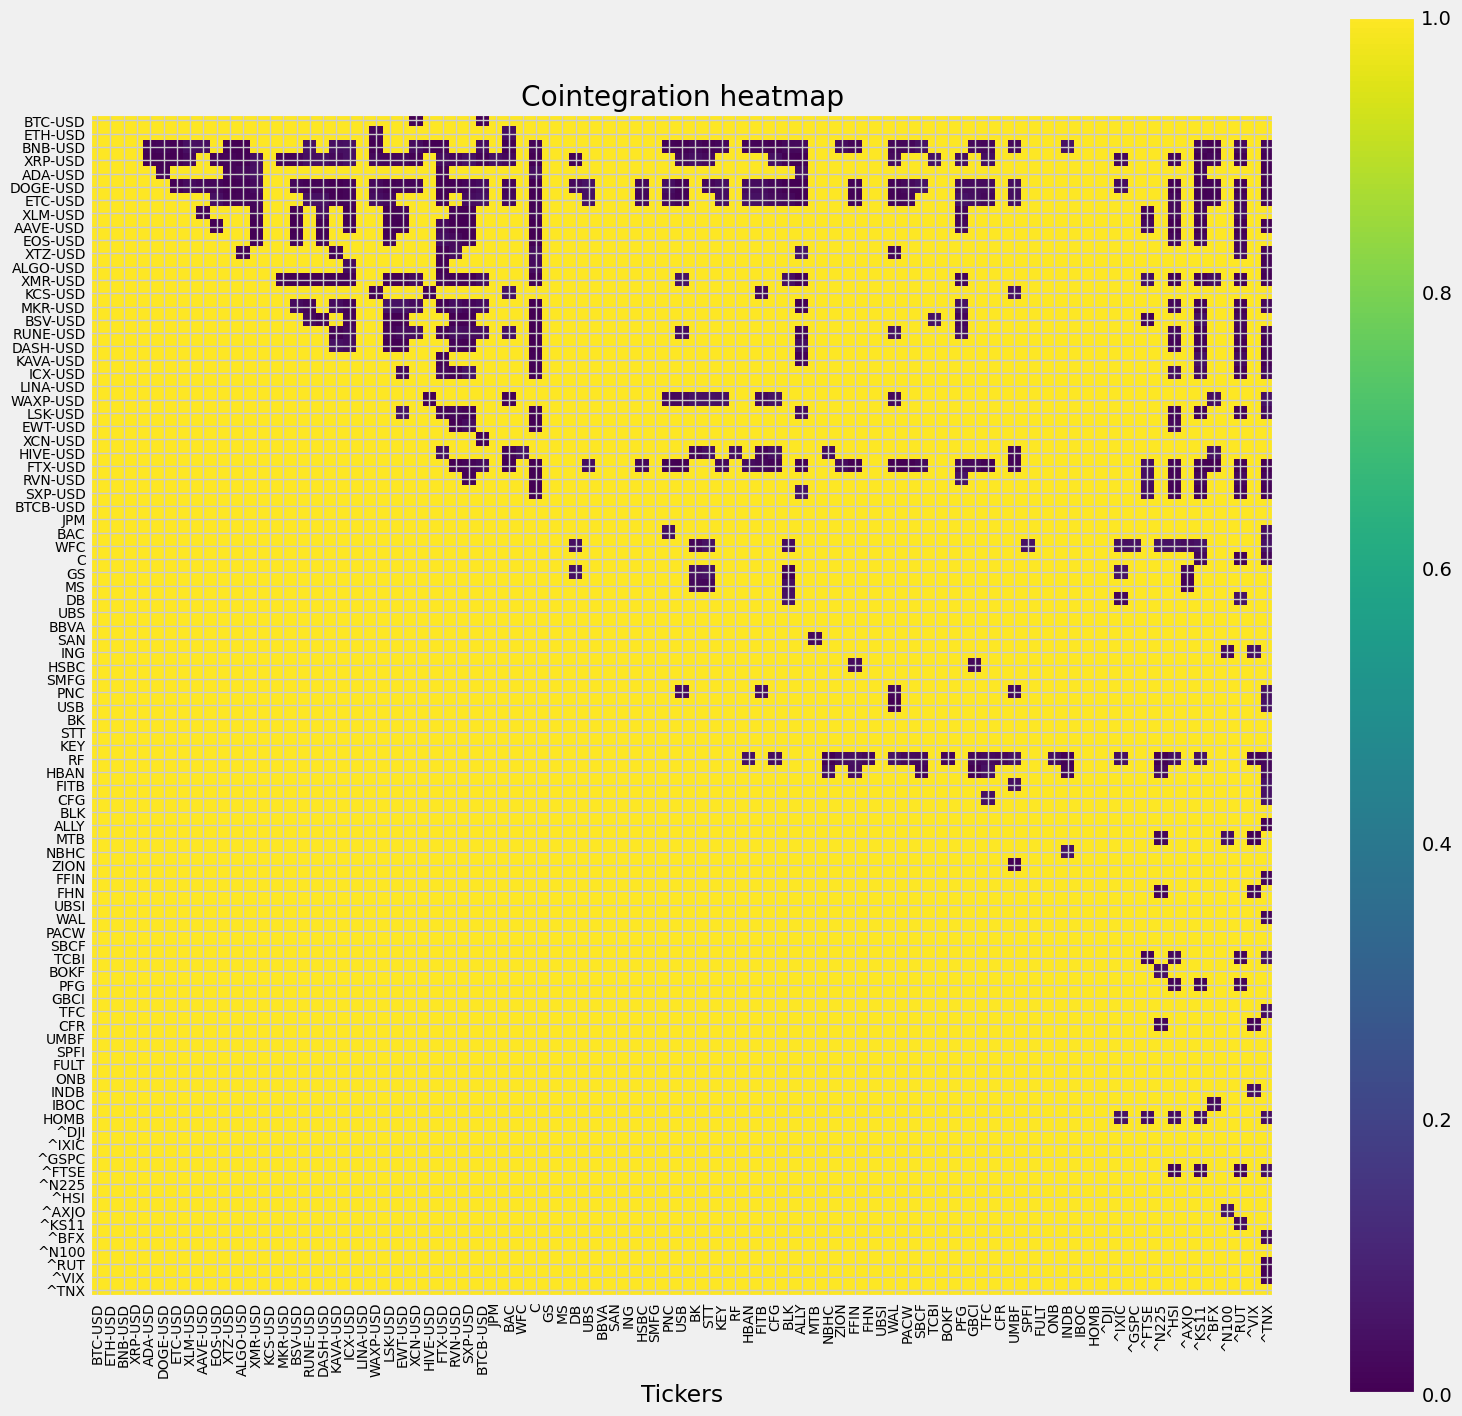

In [8]:
fig, ax = plt.subplots(figsize=(17,17))
heatmap = ax.imshow(p_values, cmap='viridis')
colorbar = plt.colorbar(heatmap)
ax.set_xticks(np.arange(len(cleaned_data.columns)), labels=cleaned_data.columns, fontsize=10)
ax.set_yticks(np.arange(len(cleaned_data.columns)), labels=cleaned_data.columns, fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Cointegration heatmap')
plt.xlabel('Tickers')
plt.show()

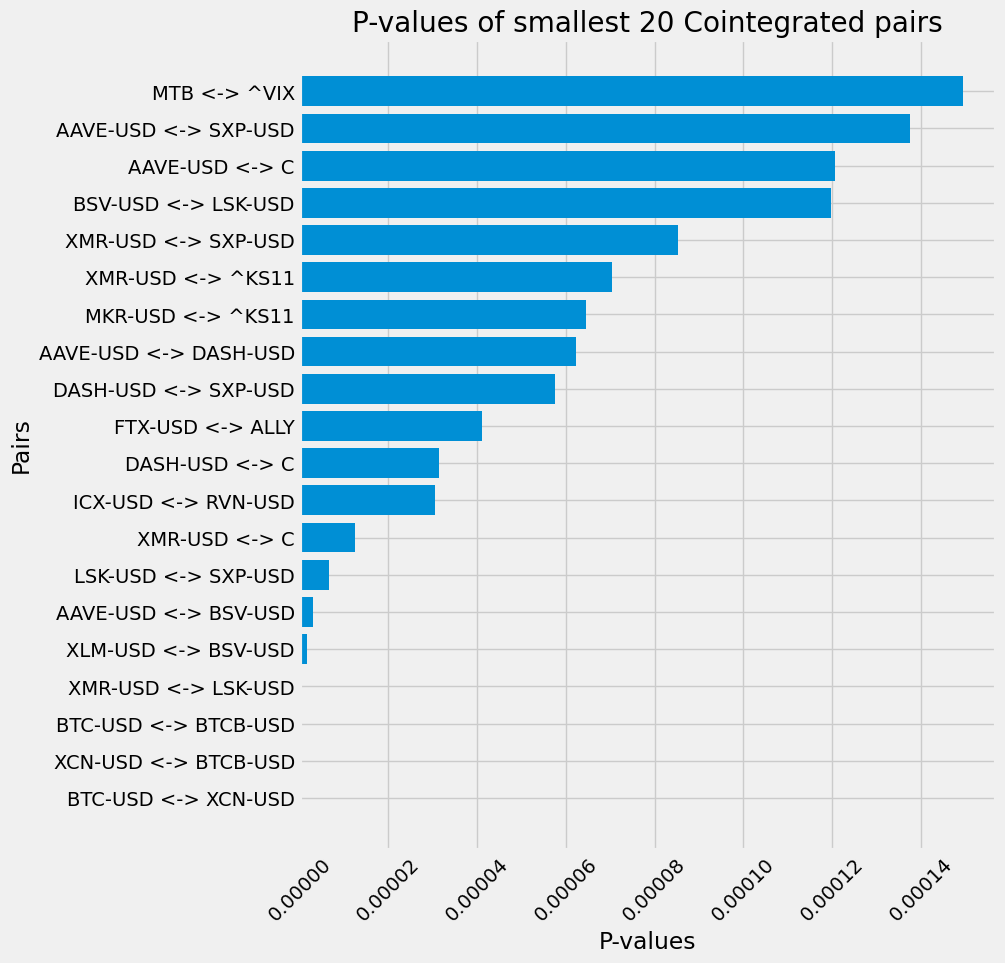

In [9]:
sorted_pairs = sorted(pairs, key=lambda x: x[2], reverse=False)
sub_sorted_pairs = sorted_pairs[0:20]
sub_sorted_pairs
pair_labels, p_vals = zip(*[(f'{y1} <-> {y2}', p) for y1, y2, p in sub_sorted_pairs])
plt.figure(figsize=(8,10))
plt.barh(pair_labels, p_vals)
plt.xticks(rotation=45)
plt.title('P-values of smallest 20 Cointegrated pairs')
plt.xlabel('P-values')
plt.ylabel('Pairs')
plt.show()

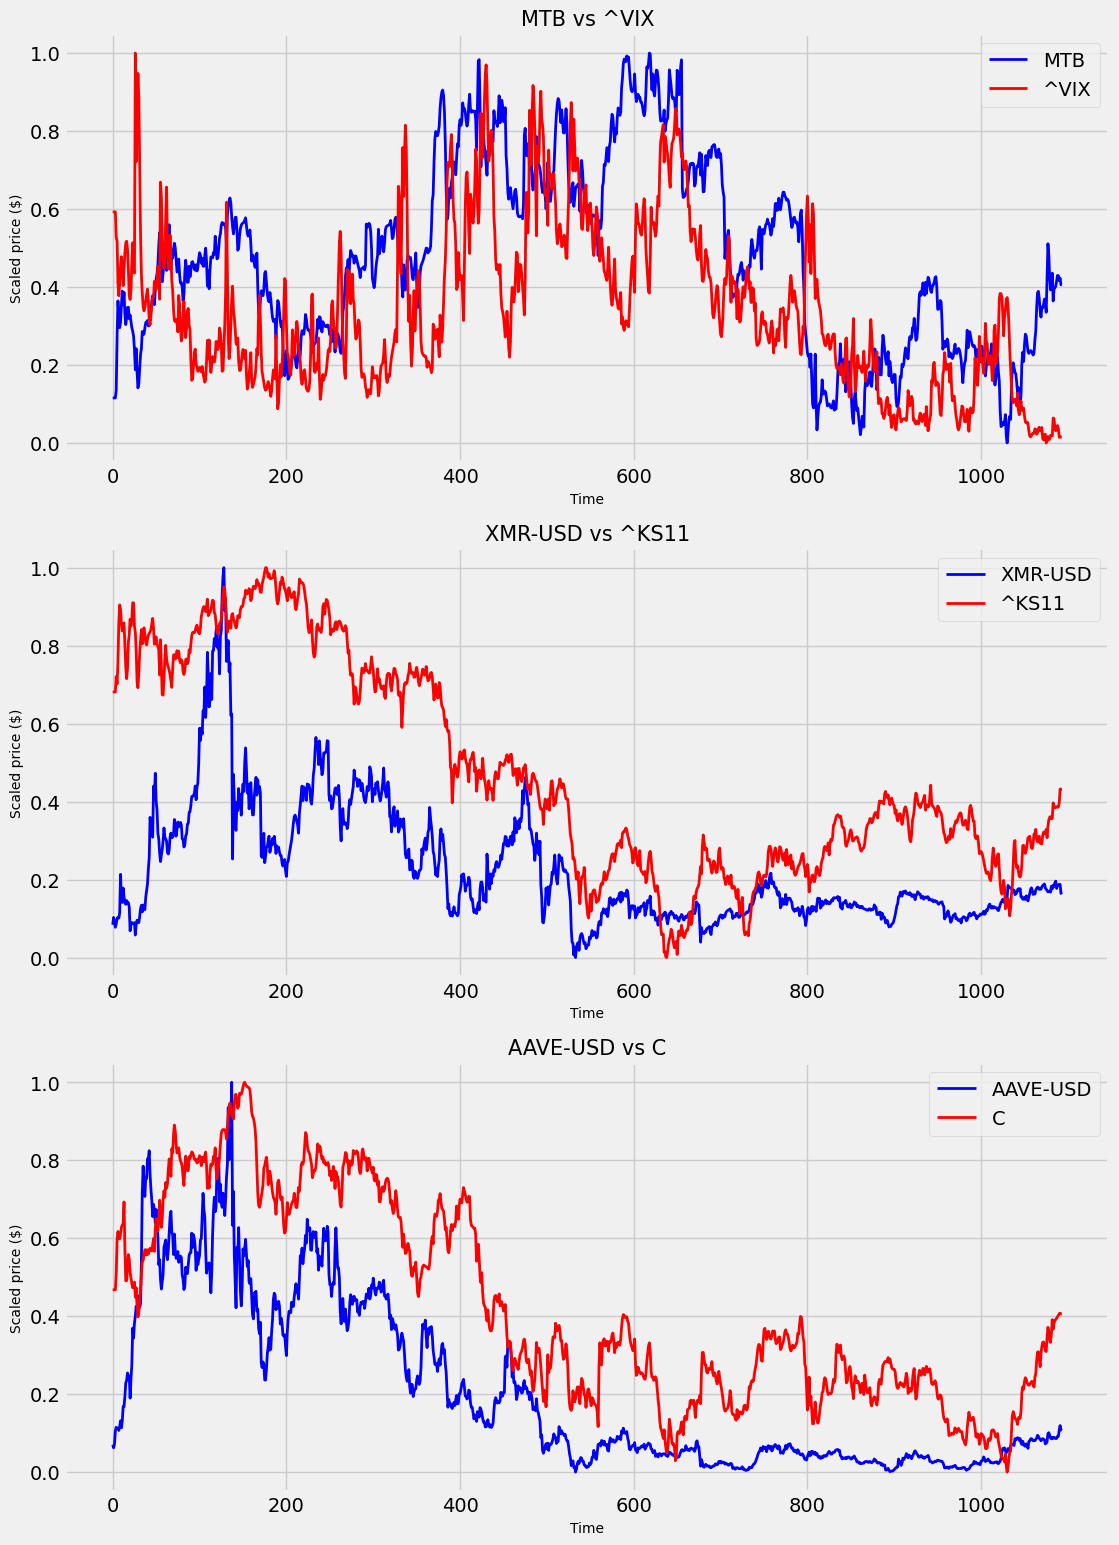

In [10]:
ticker_pairs = [('MTB', '^VIX'), ('XMR-USD', '^KS11'), ('AAVE-USD', 'C')]
fig, ax = plt.subplots(3, 1, figsize=(12,18))
scaler = MinMaxScaler()
for i, (t1, t2) in enumerate(ticker_pairs):
    scaled_data_1 = scaler.fit_transform(cleaned_data[t1].values.reshape(-1, 1))
    scaled_data_2 = scaler.fit_transform(cleaned_data[t2].values.reshape(-1, 1))
    ax[i].plot(scaled_data_1, label=t1, color='blue', linewidth=2.0)
    ax[i].plot(scaled_data_2, label=t2, color='red', linewidth=2.0)
    ax[i].set_title(f'{t1} vs {t2}', fontsize=15)
    ax[i].set_ylabel('Scaled price ($)', fontsize=10)
    ax[i].set_xlabel('Time', fontsize=10)
    ax[i].legend()

plt.show()

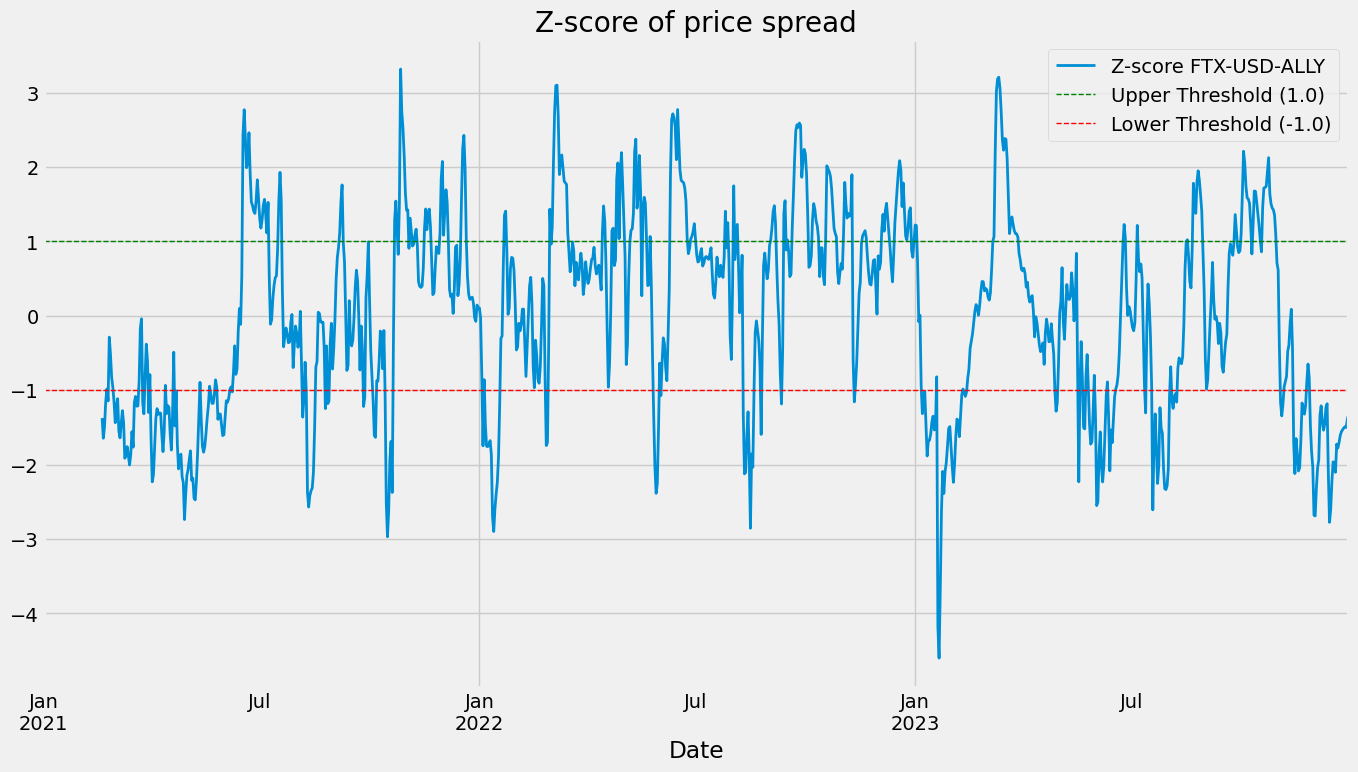

In [11]:
asset_1 = 'FTX-USD'
asset_2 = 'ALLY'
spread = pd.DataFrame()
spread[asset_1] = cleaned_data[asset_1]
spread[asset_2] = cleaned_data[asset_2]
spread[f'{asset_1}-{asset_2}'] = spread[asset_1] - spread[asset_2]
spread[f'Z-score {asset_1}-{asset_2}'] = (spread[f'{asset_1}-{asset_2}'] - spread[f'{asset_1}-{asset_2}'].rolling(window=50).mean())/spread[f'{asset_1}-{asset_2}'].rolling(window=50).std()
spread[f'Z-score {asset_1}-{asset_2}'].plot(linewidth=2.0, figsize=(15,8))

plt.axhline(1.0, color='g', linestyle='--', linewidth=1.0, label='Upper Threshold (1.0)')
plt.axhline(-1.0, color='r', linestyle='--', linewidth=1.0, label='Lower Threshold (-1.0)')
plt.title('Z-score of price spread')
plt.legend()
plt.show()

In [12]:
def signals(t1, t2, window=50):
    buy_price_1 = []
    buy_price_2 = []
    sell_price_1 = []
    sell_price_2 = []
    open_position = []
    funds = [100] * t1.shape[0]
    last_funds = 100
    flag = 0
    i = 0

    # Calculate z-score with a rolling window
    df = pd.DataFrame()
    df[t1.name] = t1
    df[t2.name] = t2
    df['Spread'] = df[t1.name] - df[t2.name]
    df['Z-score'] = (df['Spread'] - df['Spread'].rolling(window=window).mean())/df['Spread'].rolling(window=window).std()

    # Determine entry and exit thresholds
    buy_signal = df['Z-score'] > 1.0
    sell_signal = df['Z-score'] < -1.0
    exit_signal = (df['Z-score'] >= -1.0) & (df['Z-score'] <= 1.0)

    for date, buy, sell, exit in zip(df.index, buy_signal, sell_signal, exit_signal):
        if buy:
            if flag == 0:
                # Sell overvalued asset (t1) and buy undervalued asset (t2)
                flag = 1
                buy_price_1.append(np.nan)
                buy_price_2.append(df.loc[date, t2.name])
                sell_price_1.append(df.loc[date, t1.name])
                sell_price_2.append(np.nan)
                buy_pos = last_funds/df.loc[date, t2.name]
                sell_pos = -last_funds/df.loc[date, t1.name]
                funds[i] = last_funds
                open_position.append(buy_pos + sell_pos)
            elif flag == 1:
                # During an open buy (t2) and sell (t1) position
                buy_price_1.append(np.nan)
                buy_price_2.append(np.nan)
                sell_price_1.append(np.nan)
                sell_price_2.append(np.nan)
                last_funds = df.loc[date, t2.name] * buy_pos - df.loc[date, t1.name] * sell_pos
                funds[i] = last_funds
                open_position.append(buy_pos + sell_pos)
        elif sell:
            if flag == 0:
                # Sell overvalued asset (t2) and buy undervalued asset (t1)
                flag = -1
                buy_price_1.append(df.loc[date, t1.name])
                buy_price_2.append(np.nan)
                sell_price_1.append(np.nan)
                sell_price_2.append(df.loc[date, t2.name])
                buy_pos = last_funds/df.loc[date, t1.name]
                sell_pos = -last_funds/df.loc[date, t2.name]
                funds[i] = last_funds
                open_position.append(buy_pos + sell_pos)
            elif flag == -1:
                # During an open buy (t1) and sell (t2) position
                buy_price_1.append(np.nan)
                buy_price_2.append(np.nan)
                sell_price_1.append(np.nan)
                sell_price_2.append(np.nan)
                last_funds = df.loc[date, t1.name] * buy_pos - df.loc[date, t2.name] * sell_pos
                funds[i] = last_funds
                open_position.append(buy_pos + sell_pos)
        elif exit:
            if flag == 1:
                # Exit buy (t2) and sell (t1) positions
                flag = 0
                buy_price_1.append(np.nan)
                buy_price_2.append(df.loc[date, t2.name])
                sell_price_1.append(df.loc[date, t1.name])
                sell_price_2.append(np.nan)
                last_funds = funds[i-1] + (df.loc[date, t1.name] * sell_pos - df.loc[date, t2.name] * buy_pos)
                # last_funds = df.loc[date, t2.name] * buy_pos - df.loc[date, t1.name] * sell_pos
                funds[i] = last_funds
                buy_pos = 0
                sell_pos = 0
                open_position.append(0)
            elif flag == -1:
                # Exit buy (t1) and sell (t2) positions
                flag = 0
                buy_price_1.append(df.loc[date, t1.name])
                buy_price_2.append(np.nan)
                sell_price_1.append(np.nan)
                sell_price_2.append(df.loc[date, t2.name])
                last_funds = funds[i-1] + (df.loc[date, t2.name] * sell_pos - df.loc[date, t1.name] * buy_pos)
                # last_funds = df.loc[date, t1.name] * buy_pos - df.loc[date, t2.name] * sell_pos
                funds[i] = last_funds
                buy_pos = 0
                sell_pos = 0
                open_position.append(0)
        else:
            buy_price_1.append(np.nan)
            buy_price_2.append(np.nan)
            sell_price_1.append(np.nan)
            sell_price_2.append(np.nan)
            buy_pos = 0
            sell_pos = 0
            open_position.append(0)
        
        i += 1

    print(funds[48:56])
    # print(funds)
    print(len(open_position))
    print(len(funds))

    return buy_price_1, buy_price_2, sell_price_1, sell_price_2, open_position, funds, flag

In [13]:
df = pd.DataFrame()
spread[asset_1].index = pd.to_datetime(spread[asset_1], format='%Y-%m-%d', errors='coerce')
spread[asset_2].index = pd.to_datetime(spread[asset_2], format='%Y-%m-%d', errors='coerce')
buy_sell = signals(cleaned_data[asset_1], cleaned_data[asset_2])
# df[asset_1] = cleaned_data[asset_1]
# df[asset_2] = cleaned_data[asset_2]
df[f'Buy {asset_1}'] = buy_sell[0]
df[f'Sell {asset_2}'] = buy_sell[3]
df[f'Buy {asset_2}'] = buy_sell[1]
df[f'Sell {asset_1}'] = buy_sell[2]
df['Open Position'] = buy_sell[4]
# df.index = cleaned_data.index
# df['Funds'] = buy_sell[5]
df.iloc[45:65, :]
# plt.plot(buy_sell[5], linewidth=2.0)
# plt.show()

[100, 100, 196.9039545138681, 226.04873018924087, 204.4976781275647, 23.070111938471825, 23.070111938471825, -20.187188378734106]
684
1094


,Buy FTX-USD,Sell ALLY,Buy ALLY,Sell FTX-USD,Open Position
45,NaN,NaN,NaN,NaN,0.000000
46,NaN,NaN,NaN,NaN,0.000000
47,NaN,NaN,NaN,NaN,0.000000
48,NaN,NaN,NaN,NaN,0.000000
49,0.006231,39.068157,NaN,NaN,16046.228220
50,NaN,NaN,NaN,NaN,16046.228220
51,NaN,NaN,NaN,NaN,16046.228220
52,NaN,NaN,NaN,NaN,16046.228220
53,0.005148,38.602623,NaN,NaN,0.000000
54,0.005559,38.967739,NaN,NaN,4149.454949


In [ ]:
# plt.figure(figsize = (15, 8))
# plt.plot(cleaned_data[asset_1], label=asset_1, linewidth=2.0, color='black')
# plt.plot(cleaned_data[asset_2], label=asset_2, linewidth=2.0, color='blue')
# plt.scatter(cleaned_data.index, df[f'Buy {asset_1}'], label='Buy', marker='^', color='green', s=70)
# plt.scatter(cleaned_data.index, df[f'Buy {asset_2}'], label='Buy', marker='^', color='yellow', s=70)
# plt.scatter(cleaned_data.index, df[f'Sell {asset_1}'], label='Sell', marker='v', color='red', s=70)
# plt.scatter(cleaned_data.index, df[f'Sell {asset_1}'], label='Sell', marker='v', color='orange', s=70)
# plt.title(f'{asset_1} {asset_2} Buy-Sell Signals')
# plt.xlabel('Time')
# plt.ylabel('Close price ($)')
# plt.legend()
# plt.show()